In [1]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
import time

Using TensorFlow backend.


In [2]:
dt = pd.read_csv("sudoku_dataset/sudoku.csv")
print(dt.shape)

(1000000, 2)


In [3]:
def create_dataframe(string):
    array = list(string)
    reshaped = np.reshape(array, (9,9))
    return pd.DataFrame(reshaped)

In [4]:
puz = create_dataframe(dt["quizzes"][0])
sol = create_dataframe(dt["solutions"][0])
print("quiz")
display(puz)
print("solution")
display(sol)

quiz


,0,1,2,3,4,5,6,7,8
0,0,0,4,3,0,0,2,0,9
1,0,0,5,0,0,9,0,0,1
2,0,7,0,0,6,0,0,4,3
3,0,0,6,0,0,2,0,8,7
4,1,9,0,0,0,7,4,0,0
5,0,5,0,0,8,3,0,0,0
6,6,0,0,0,0,0,1,0,5
7,0,0,3,5,0,8,6,9,0
8,0,4,2,9,1,0,3,0,0


solution


,0,1,2,3,4,5,6,7,8
0,8,6,4,3,7,1,2,5,9
1,3,2,5,8,4,9,7,6,1
2,9,7,1,2,6,5,8,4,3
3,4,3,6,1,9,2,5,8,7
4,1,9,8,6,5,7,4,3,2
5,2,5,7,4,8,3,9,1,6
6,6,8,9,7,3,4,1,2,5
7,7,1,3,5,2,8,6,9,4
8,5,4,2,9,1,6,3,7,8


In [5]:
from keras.utils import to_categorical

def preprocessing_data(data):
    array = [list(map(int,list(i))) for i in data]
    return to_categorical(array, num_classes=10)

In [6]:
epochs = 10
batch = 32
train_size = 200000
test_size = 10000

In [7]:
x_train = np.array(range(train_size))
y_train = np.array(range(train_size))

x_test = np.array(range(train_size, train_size+test_size))
y_test = np.array(range(train_size, train_size+test_size))
print(x_train.shape)
print(x_test.shape)

(200000,)
(10000,)


In [8]:
# x_train = preprocessing_data(dt["quizzes"][:train_size])
# y_train = preprocessing_data(dt["solutions"][:train_size])

# x_test = preprocessing_data(dt["quizzes"][train_size:train_size+test_size])
# y_test = preprocessing_data(dt["solutions"][train_size:train_size+test_size])

# print(y_train.shape)
# print(y_train)

In [9]:
from keras.utils import Sequence

class SudokuSequence(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return preprocessing_data(dt["quizzes"][batch_x]), preprocessing_data(dt["solutions"][batch_y])

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Reshape, Dropout, BatchNormalization, Activation

model = Sequential()
model.add(Flatten(input_shape=(81,10)))
model.add(Dense(810))
model.add(Activation('relu'))
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(0.3))
model.add(Dense(810))
model.add(Reshape((81,10)))
# model.add(BatchNormalization())
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs/{}'.format(int(time.time())), histogram_freq=0, write_graph=True, write_images=True)

# history = model.fit(x_train, y_train, validation_split=0.125, epochs=epochs, batch_size=batch, callbacks=[tbCallBack])
history = model.fit_generator(
    generator=SudokuSequence(x_train, y_train, batch), 
    steps_per_epoch=len(x_train)//batch, 
    epochs=epochs, callbacks=[tbCallBack], 
    validation_data=SudokuSequence(x_test, y_test, batch), 
    validation_steps=len(x_test)//batch)

# score = model.evaluate(x_test, y_test, batch_size=batch)
# print(score)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 810)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 810)               656910    
_________________________________________________________________
activation_3 (Activation)    (None, 810)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 810)               656910    
_________________________________________________________________
reshape_2 (Reshape)          (None, 81, 10)            0         
_________________________________________________________________
activation_4 (Activation)    (None, 81, 10)            0         
Total params: 1,313,820
Trainable params: 1,313,820
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.save("model_1.h5")

In [ ]:
from keras.models import load_model

model = load_model("model_1.h5")

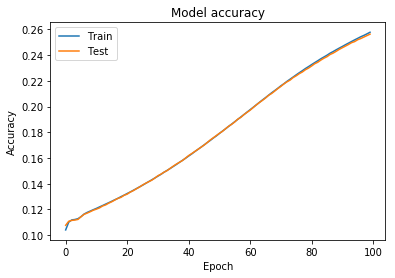

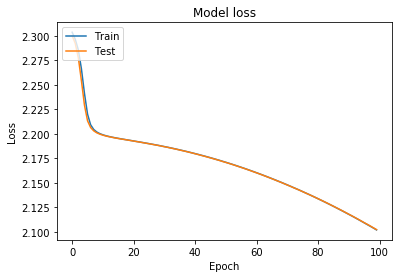

In [59]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [55]:
x = np.argmax(preprocessing_data(dt["quizzes"][x_test[0]]), axis=1)
y = np.argmax(preprocessing_data(dt["solutions"][y_test[0]]), axis=1)

p = model.predict(preprocessing_data(dt["quizzes"][x_test[0]]).reshape((1,81,10)))
p = p.reshape((81,10))
p = [np.argmax(i) for i in p]

puz = create_dataframe(x)
sol = create_dataframe(y)
pre = create_dataframe(p)

print("quiz")
display(puz)
print("solution")
display(sol)
print("predicted")
display(pre)

quiz


,0,1,2,3,4,5,6,7,8
0,7,0,1,0,2,8,3,9,0
1,2,3,0,0,0,4,8,0,0
2,0,0,9,0,0,0,0,0,4
3,9,0,0,0,3,2,1,7,0
4,0,0,8,0,9,0,5,4,0
5,1,0,6,0,0,7,0,0,8
6,4,6,0,0,0,9,7,0,0
7,0,1,0,0,6,0,0,0,0
8,0,0,7,5,0,0,0,0,3


solution


,0,1,2,3,4,5,6,7,8
0,7,4,1,6,2,8,3,9,5
1,2,3,5,9,1,4,8,6,7
2,6,8,9,3,7,5,2,1,4
3,9,5,4,8,3,2,1,7,6
4,3,7,8,1,9,6,5,4,2
5,1,2,6,4,5,7,9,3,8
6,4,6,3,2,8,9,7,5,1
7,5,1,2,7,6,3,4,8,9
8,8,9,7,5,4,1,6,2,3


predicted


,0,1,2,3,4,5,6,7,8
0,7,4,1,9,8,8,3,9,3
1,7,3,9,1,7,4,8,8,2
2,8,8,9,3,2,3,4,7,4
3,9,9,9,4,3,2,7,8,8
4,1,7,8,9,9,9,1,4,6
5,1,2,3,7,1,7,9,9,9
6,3,3,8,7,2,9,8,1,5
7,5,1,7,2,4,3,9,1,4
8,6,9,7,7,8,1,9,1,3
